#  Анализ тематических особенностей и временных трендов в поэзии Якуба Коласа


**Описание:**  
Данные берутся с сайта [knihi.com](https://knihi.com) - коллекции стихотворений белорусских классиков. Я собирала стихи одного из самых ярких представителей беларусской литературы - Якуба Коласа, содержащие определённые ключевые слова (например, «кроў», «жыццё», «любоў» и др.).  
**Цель** - проанализировать частотность ключевых слов, объединить слова по тематикам, выявить топовые и редкие слова вне ключевых, а также изучить распределение длины стихов и их количество по годам публикации. А также исследовать взаимосвязь динамики творческой активности и тематических предпочтений с внешними историческими и социальными факторами (например, периодами войн, культурных изменений и т.д.), чтобы понять, как события времени влияли на содержание и форму поэзии Якуба Коласа.

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import requests
from bs4 import BeautifulSoup
import time
import re
import csv

---

## Загрузка данных  
В этом разделе отображена загрузка стихов с сайта, фильтрация по ключевым словам, сохранение в файлы JSON и CSV.  
Весь код сбора данных можно вынесен в отдельный скрипт `scripts/collect_poems.py`, но здесь он продублирован для запуска с нуля.


In [2]:
BASE_URL = "https://knihi.com"

HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
        "(KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"
    )
}


KEYWORDS = [
    "кроў", "жыццё", "вецер", "зямля", "любоў", "смутак", "вясна", "зімa", "сонца",
    "душа", "сэрца", "боль", "шчасце", "святло", "цені", "надзея", "памяць", "воля"
]

MAX_POEM_LENGTH = 2000  # Ограничение максимальной длины текста

AUTHORS = {
    "Jakub_Kolas": "Якуб Колас",
}

def get_soup(url):
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        response.raise_for_status()
        response.encoding = 'utf-8'
        return BeautifulSoup(response.text, "html.parser")
    except Exception as e:
        print(f"Ошибка при загрузке {url}: {e}")
        return None

def is_poem_page(url):
    soup = get_soup(url)
    if soup is None:
        return False
    poem_div = soup.find("div", class_="POETRY")
    if poem_div:
        text = poem_div.get_text(strip=True)
        return len(text) <= MAX_POEM_LENGTH
    return False

def parse_poem_page(url):
    soup = get_soup(url)
    if soup is None:
        return None

    h2_tags = soup.find_all("h2")
    if len(h2_tags) >= 2:
        title = h2_tags[1].text.strip().strip('"')
        author = h2_tags[0].text.strip()
    else:
        title = "Без названия"
        author = "Неизвестен"

    year = None
    i_tag = soup.find("i")
    if i_tag:
        date_text = i_tag.get_text(strip=True)
        year_match = re.search(r'(\d{4})', date_text)
        if year_match:
            year = year_match.group(1)

    poem_div = soup.find("div", class_="POETRY")
    text = ""
    if poem_div:
        text = poem_div.get_text(separator="\n").strip()

    result = {
        "title": title,
        "author": author,
        "year": year,
        "url": url,
        "text": text
    }
    return result



def collect_poems(author_key, author_name, limit=101):
    author_url = f"{BASE_URL}/{author_key}/"
    soup = get_soup(author_url)
    if soup is None:
        print(f"Не удалось загрузить страницу автора {author_name}")
        return []

    poem_links = set()
    for a in soup.find_all("a", href=True):
        href = a['href'].strip()
        if href.startswith("javascript:") or href.startswith("#") or href.startswith("mailto:") or href == "":
            continue
        if href.startswith(f"/{author_key}/") and href.endswith(".html") and "_book" not in href:
            full_url = BASE_URL + href
            poem_links.add(full_url)

    print(f"{author_name}: найдено уникальных ссылок: {len(poem_links)}")

    poems = []
    count = 0
    for link in poem_links:
        if count >= limit:
            break
        try:
            if not is_poem_page(link):
                continue
            poem = parse_poem_page(link)
            if poem is None:
                continue


            soup_poem = get_soup(link)
            if soup_poem is None:
                continue
            poem_div = soup_poem.find("div", class_="POETRY")
            if poem_div is None:
                continue
            text_lower = poem_div.get_text(separator="\n").lower()
            if any(word in text_lower for word in KEYWORDS):
                poems.append(poem)  # Добавляем без текста
                count += 1
                print(f"{author_name}: собран стих '{poem['title']}'")
            time.sleep(0.3)
        except Exception as e:
            print(f"Ошибка при парсинге {link}: {e}")

    print(f"{author_name}: собрано стихотворений с ключевыми словами: {len(poems)}\n")
    return poems

def save_poems_to_csv(poems, filename="poems_dataset.csv"):
    """Сохраняет полный датасет с текстом стихотворений"""
    with open(filename, "w", encoding="utf-8", newline='') as csvfile:
        fieldnames = ["title", "author", "year", "url", "text"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for poem in poems:
            writer.writerow(poem)
    print(f"Данные сохранены в {filename}")


def main():
    all_poems = []
    for author_key, author_name in AUTHORS.items():
        poems = collect_poems(author_key, author_name, limit=101)
        all_poems.extend(poems)

    save_poems_to_csv(all_poems, filename="poems_dataset.csv")


    with open("poems_dataset.json", "w", encoding="utf-8") as f:
        json.dump(all_poems, f, ensure_ascii=False, indent=4)

    print(f"Всего собрано стихотворений: {len(all_poems)}")


Что парсится:

- Страница автора содержит множество ссылок на отдельные стихи

- Каждое стихотворение находится на отдельной HTML-странице с текстом внутри блока с классом POETRY

- Извлекаются название, автор, год публикации, URL и текст стихотворения

Что используется для оптимизации парсинга:

- Используется фильтрация по длине текста и наличию ключевых слов для отбора релевантных стихов

- Максимальное количество собираемых стихотворений ограничено параметром limit (101)

- Добавлена проверка наличия блока POETRY и повторные попытки загрузки, если на странице отсутвует блок с текстом

- Для снижения нагрузки на сервер добавлена пауза между запросами 

Результаты сохраняются в локальные файлы JSON и CSV для последующего анализа в формате:

    {
      "title": " ",
      "author": " ",
      "year": " ",
      "url": "https:// ",
       "text": " "
     }


---

## Очистка данных и подготовка к анализу  

**В данном разделе:**

- Загрузка данных и приведение к DataFrame.

- Приводие года к числовому типу с обработкой пропусков.

- Добавление колонки с длиной текста для анализа размера стихов.

- Вывод базовой информации по таблице: размеры, типы данных, пропуски.

- Построение гистограммы распределения по годам и длине стихов для выявления трендов и аномалий.




In [6]:
df = pd.read_json('poems_dataset.json')
df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')
df['text_length'] = df['text'].apply(len) #добавление колонки с длиной текста
display(df.head(10))

,title,author,year,url,text,text_length
0,Дарога...,Якуб Колас,1916,https://knihi.com/Jakub_Kolas/Daroha_ad_kurhan...,"Ад кургана да кургана,\n\n\nАд гаю да гаю\n\n\...",391
1,Чуваць вясна,Якуб Колас,1938,https://knihi.com/Jakub_Kolas/Cuvac_viasna.html,"Не сышлі яшчэ з нізіны\n\n\nРоспісы зімы,\n\n\...",657
2,Пахмелле,Якуб Колас,1911,https://knihi.com/Jakub_Kolas/Pachmielle.html,"– Годзе, жонка! Ну, не лайся:\n\n\nБольш гарэл...",1017
3,Старыя песні,Якуб Колас,1914,https://knihi.com/Jakub_Kolas/Staryja_piesni.html,"Скарга нязменная, гора нязбытае...\n\n\nГоль з...",391
4,Роднаму краю,Якуб Колас,1943,https://knihi.com/Jakub_Kolas/Rodnamu_kraju_ja...,Мой край ясназоры! Прайшоў ты нямала\n\n\nШыро...,1232
5,Найдаражэйшы падарунак,Якуб Колас,1953,https://knihi.com/Jakub_Kolas/Najdarazejsy_pad...,Мне ўнукі дзеда Талаша\n\n\nПрыслалі падарунак...,224
6,Надрывайся і шумі...,Якуб Колас,1910,https://knihi.com/Jakub_Kolas/Nadryvajsia_i_su...,"Надрывайся і шумі,\n\n\nВецер злосны, ў полі!\...",274
7,Кветка,Якуб Колас,1910,https://knihi.com/Jakub_Kolas/Kvietka.html,За агарожаю перад астрогам\n\n\nЎ ціхім куточк...,809
8,Вясна,Якуб Колас,1907,https://knihi.com/Jakub_Kolas/Viasna_pryjdzie....,"Вясна прыйдзе, снег пагіне,\n\n\nВышэй сонца х...",433
9,Скора ў полі забушуе...,Якуб Колас,1909,https://knihi.com/Jakub_Kolas/Skora_u_poli_zab...,"Скора ў полі забушуе,\n\n\nПесню сівер запяе,\...",308


In [6]:
print("Размер таблицы:", df.shape)
print("\nИнформация о типах и пропусках:")
print(df.info())

Размер таблицы: (101, 6)

Информация о типах и пропусках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        101 non-null    object
 1   author       101 non-null    object
 2   year         98 non-null     Int64 
 3   url          101 non-null    object
 4   text         101 non-null    object
 5   text_length  101 non-null    int64 
dtypes: Int64(1), int64(1), object(4)
memory usage: 5.0+ KB
None


In [7]:
print("\nКоличество пропущенных значений по столбцам:")
print(df.isnull().sum())


Количество пропущенных значений по столбцам:
title          0
author         0
year           3
url            0
text           0
text_length    0
dtype: int64


In [8]:
print("\nСтатистика по числовым колонкам:")
display(df.describe())


Статистика по числовым колонкам:


,year,text_length
count,98.0,101.000000
mean,1925.397959,727.841584
std,15.79491,368.080120
min,1906.0,123.000000
25%,1910.0,457.000000
50%,1921.0,657.000000
75%,1941.0,899.000000
max,1953.0,2102.000000


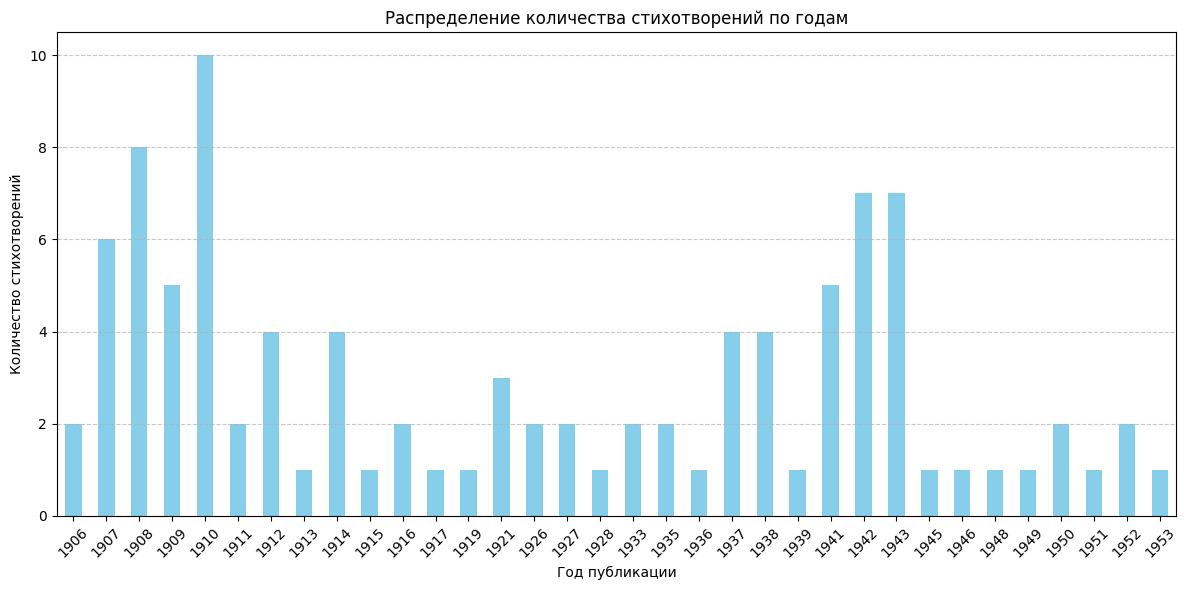

In [9]:
plt.figure(figsize=(12,6))
df['year'].dropna().astype(int).value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Распределение количества стихотворений по годам')
plt.xlabel('Год публикации')
plt.ylabel('Количество стихотворений')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

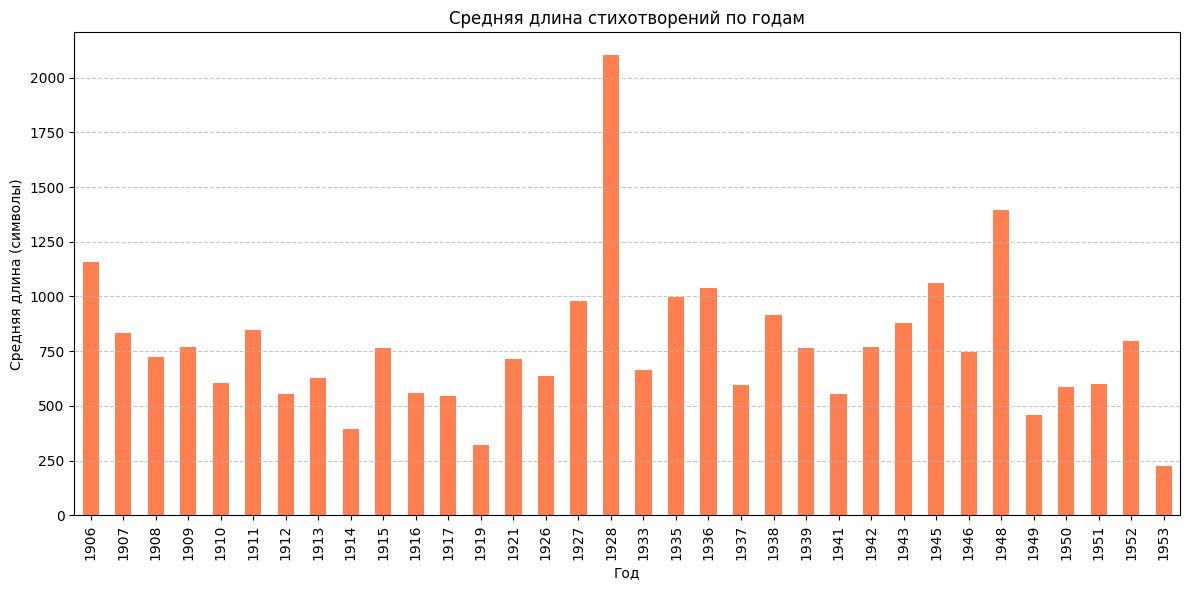

In [7]:
df_filtered = df.dropna(subset=['year', 'text']).copy()
df_filtered['text_length'] = df_filtered['text'].apply(len)

plt.figure(figsize=(12,6))
grouped = df_filtered.groupby('year')['text_length'].mean()
grouped.plot(kind='bar', color='coral')
plt.title('Средняя длина стихотворений по годам')
plt.xlabel('Год')
plt.ylabel('Средняя длина (символы)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Заключение по результатам разведочного анализа данных (EDA)

### **Общее состояние данных**

- В датасете полностью заполнены поля: title, author, url, text, text_length

- Поле year содержит 3 пропуска из-за отсутствия информации на источнике

### **Основные наблюдения**

**Распределение по годам:**

- Собранны стихотворения в диапазоне с 1906 по 19503 годы
- 
- Пропуски по году не ограничивают временной анализ (из-за небольшого количества)
- 
- Пики активности:

1. 1907–1910: Начало литературной карьеры Якуба Коласа. В этот период он публиковал первые сборники, такие как "Песні жальбы" (1910), что объясняет высокую продуктивность.

2. 1941–1943: Годы Великой Отечественной войны. Коласа активно писал патриотические и лирические произведения, отражающие трагедию войны и сопротивление оккупации.

  Можно сделать вывод, что революция 1905–1907 годов и Первая мировая война повлияли не только на количество выпущенных Коласам стихотворений, но и на их тематику ранних.

  В 1920–1930-е годы продуктивность могла снизиться из-за политических репрессий и необходимости адаптироваться к советской идеологии.


**Длина стихотворений:**

- Большинство стихотворений имеют длину менее 2000 символов, что соответствует установленному ограничению, которое было определено для исключения парсинга больших произведений 

- На графике наблюдается явный пик длины текста, которая близка к верхнему ограничению, что может указывать на небольшое число стихотворений в этот год или на написание автором поэм или циклов.





---
# Анализ и визуализация

В данном разделе представлены результаты проведения ключевых этапов визуализации и аналитики, которые помогли выявить основные тематические и временные особенности поэзии автора

### Частота ключевых слов

В данном графике отображена частота вхождения заранее выбранных ключевых слов (которые были применены как ключевые при парсинге), . Для  наглядности построена столбчатая диаграмма с переводом ключевых слов на русский язык.

На графике видно, что наиболее часто встречаются слова «любовь», «жизнь» и «свет», что указывает на центральные мотивы творчества.

Менее частые слова, такие как «надежда» или «воля», также присутствуют, но с меньшей интенсивностью.

### Облако слов
Для более глубокого лексического анализа построено два облака слов:

- Топ 15 самых частых слов вне ключевых - они отражают наиболее употребляемые слова, не входящие в список ключевых, что помогает понять дополнительные темы и стилистические особенности.

- Топ 15 самых редких слов - позволяют выявить уникальные или редко встречающиеся лексические единицы, которые могут быть важны для интерпретации отдельных стихотворений.

Для фильтрации использовался простой критерий - длина слова более 4 символов, что помогло исключить служебные слова и союзы.

### Частота ключевых слов по тематическим группам
На данном графике представлена суммарная частота вхождения ключевых слов, сгруппированных по основным тематикам, встречающимся в поэзии Якуба Коласа. Для анализа были выделены следующие тематические группы: «Природа», «Чувства» и «Душевные состояния». Данный график позволит определить доминирующие мотивы в стихотворениях автора


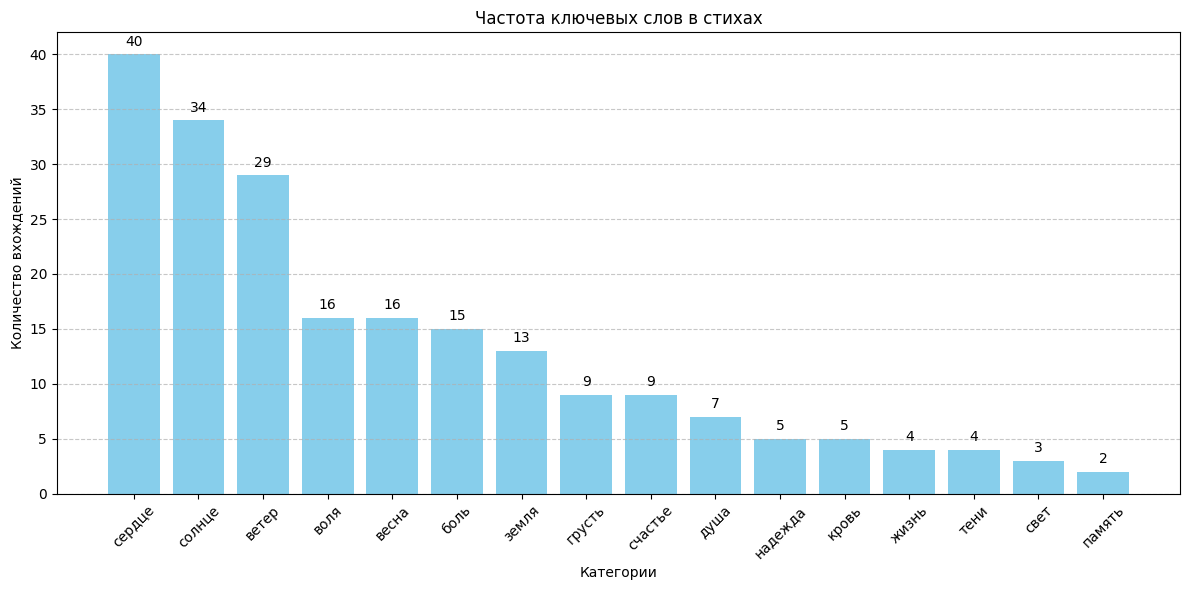

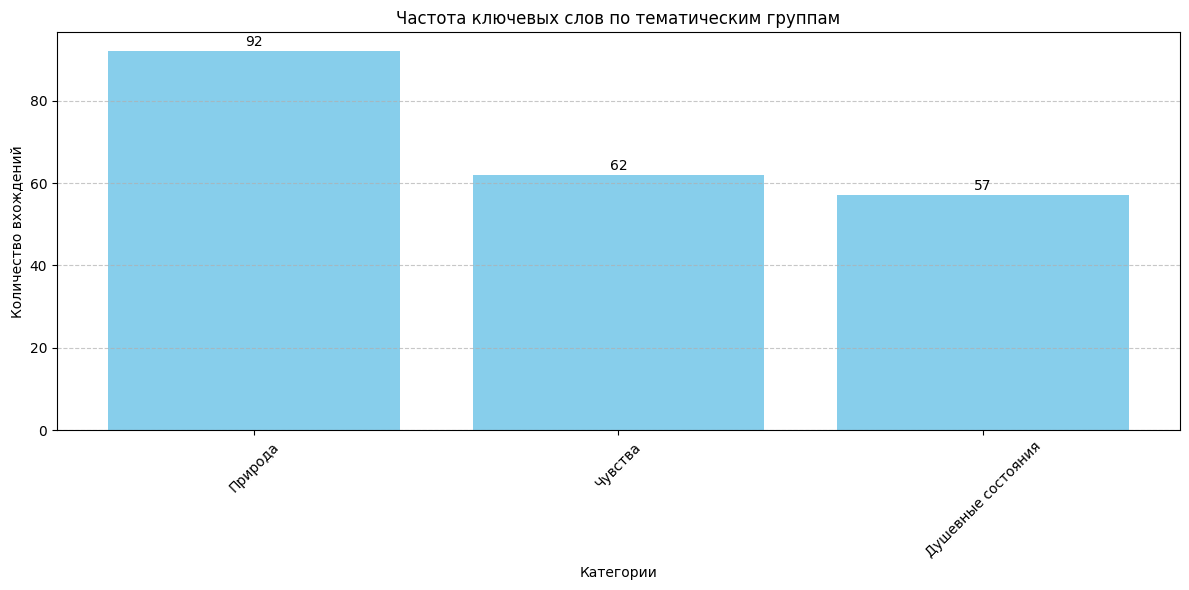

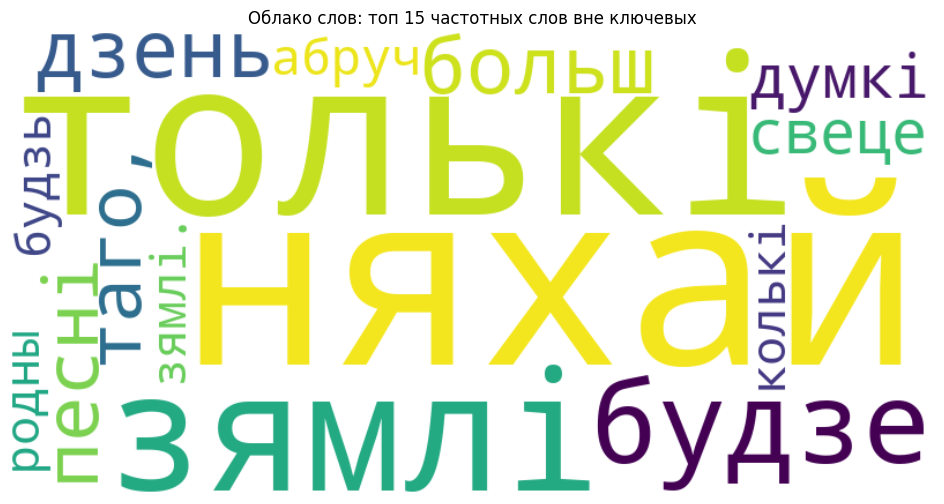

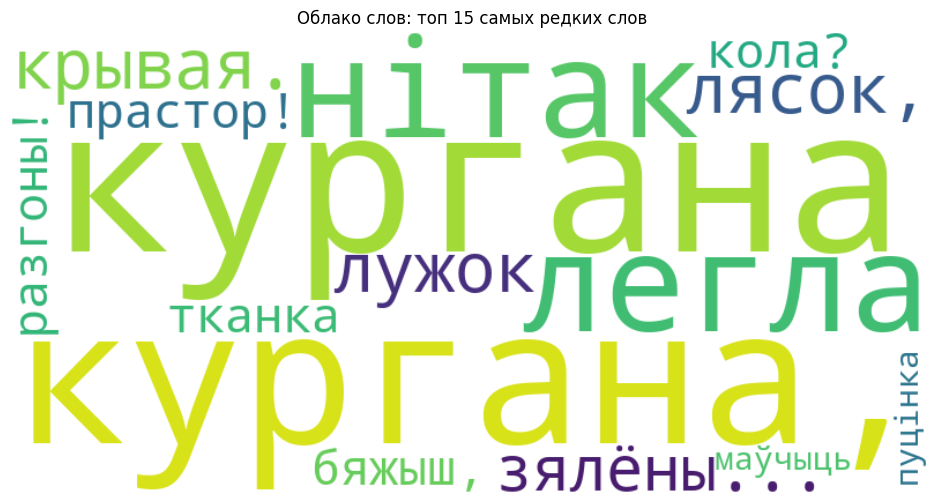

In [8]:
KEYWORDS = [
    "кроў", "жыццё", "вецер", "зямля", "любоў", "смутак", "вясна", "зімa", "сонца",
    "душа", "сэрца", "боль", "шчасце", "святло", "цені", "надзея", "памяць", "воля"
]

BEL_RU = {
    "кроў": "кровь", "жыццё": "жизнь", "вецер": "ветер", "зямля": "земля", "любоў": "любовь",
    "смутак": "грусть", "вясна": "весна", "зімa": "зима", "сонца": "солнце", "душа": "душа",
    "сэрца": "сердце", "боль": "боль", "шчасце": "счастье", "святло": "свет", "цені": "тени",
    "надзея": "надежда", "памяць": "память", "воля": "воля"
}

THEME_GROUPS = {
    "Природа": ["вецер", "зямля", "вясна", "зімa", "сонца"],
    "Чувства": ["любоў", "смутак", "шчасце", "боль", "надзея", "воля", "кроў", "святло"],
    "Душевные состояния": [ "жыццё", "душа", "сэрца","цені", "памяць"],
}

def load_poems_texts(json_filename):
    with open(json_filename, 'r', encoding='utf-8') as f:
        poems = json.load(f)
    return poems

def count_keywords_frequency(texts, keywords):
    counter = Counter()
    for text in texts:
        text_lower = text.lower()
        for word in keywords:
            count = text_lower.count(word.lower())
            if count > 0:
                counter[word] += count
    return counter

def count_frequency_by_groups(texts, theme_groups):
    group_freq = {group: 0 for group in theme_groups}
    for text in texts:
        text_lower = text.lower()
        for group, words in theme_groups.items():
            for word in words:
                group_freq[group] += text_lower.count(word)
    return group_freq

def plot_bar(freq_counter, title='Частота ключевых слов'):
    words = list(freq_counter.keys())
    counts = list(freq_counter.values())

    plt.figure(figsize=(12,6))
    bars = plt.bar(words, counts, color='skyblue')
    plt.title(title)
    plt.xlabel('Категории')
    plt.ylabel('Количество вхождений')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(height), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def plot_wordcloud(freq_dict, title='Облако слов'):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        collocations=False
    ).generate_from_frequencies(freq_dict)

    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

def main():
    poems = load_poems_texts('poems_dataset.json')
    texts = [poem.get('text', '') for poem in poems]

    # Частоты по всем ключевым словам
    freq_counter = count_keywords_frequency(texts, KEYWORDS)
    if not freq_counter:
        print("Ключевые слова не найдены в текстах.")
        return

    freq_counter_ru = {BEL_RU[word]: count for word, count in freq_counter.items()}
    freq_counter_ru = dict(sorted(freq_counter_ru.items(), key=lambda x: x[1], reverse=True))
    plot_bar(freq_counter_ru, title='Частота ключевых слов в стихах')

    # Частоты по тематическим группам
    freq_by_theme = count_frequency_by_groups(texts, THEME_GROUPS)
    plot_bar(freq_by_theme, title='Частота ключевых слов по тематическим группам')

    # Облако слов топ 15 частотных вне ключевых
    all_words = []
    for text in texts:
        words = text.lower().split()
        all_words.extend(words)

    filtered_words = [w for w in all_words if len(w) > 4 and w not in KEYWORDS]
    counter_all = Counter(filtered_words)
    top15_non_keywords = dict(counter_all.most_common(15))
    plot_wordcloud(top15_non_keywords, title='Облако слов: топ 15 частотных слов вне ключевых')

    # Облако слов топ 15 самых редких слов
    rare_words = [item for item in counter_all.items() if item[1] > 0]
    rare_words_sorted = sorted(rare_words, key=lambda x: x[1])
    top15_rare_words = dict(rare_words_sorted[:15])
    plot_wordcloud(top15_rare_words, title='Облако слов: топ 15 самых редких слов')

if __name__ == "__main__":
    main()

# Выводы по графикам
**Частотность распределения слов**

1) Анализ диаграммы частоты ключевых слов показывает, что в поэзии Якуба Коласа наиболее часто встречаются слова «сердце», «солнце» и «ветер». Это говорит о том, что образы природы и внутреннего мира человека занимают центральное место в его творчестве. Высокая частота слова «сердце» подчеркивает важность эмоциональных и чувственных мотивов, а частое употребление «солнца» и «ветра» отражает тесную связь поэта с природой.

2) Это подверждается анализом графика группировки ключевых слов по тематикам. Он позволил выявить, какие мотивы доминируют в корпусе стихотворений.

Природа - самая частотная группа. Это подверждает связь с с национальными традициями, сельским образом жизни и личным восприятием автора.

В целом, анализ по тематическим группам показал гармоничное сочетание природных, эмоциональных и душевных мотивов поэтического стиля Якуба Коласа.

**Облаки слов**

1) Первый график наиболее часто встречающихся слов, не входящих в список ключевых, позволяет выявить дополнительные темы и детали, важные для поэта, которые не были отмечены как ключевые. График позволяет увидеть слова, связанные с землёй, временем, местами, что расширяет представление о лексическом многообразии поэзии Коласа.

2) Второй график уникальных и специфические слов, которые встречаются лишь в отдельных стихах, позволил определить некоторые недочеты в парсинге текста стихотворений. В некоторых словах знак запятой, восклицательного и вопросительного знаков, ударения считываются как одно слово. Таким образом, данный график не только помогает выявить редкие и уникальные слова, но и указывает на необходимость доработки этапа предобработки текстов для более точного и корректного анализа.

### **Общий итог**

В поэзии Якуба Коласа доминируют природные и эмоциональные мотивы, что подтверждается как частотным анализом ключевых слов, так и их тематической группировкой.

Внутренний мир, память и душевные состояния также играют важную роль, отражая глубину поэтических текстов.

Лексический анализ вне ключевых слов выявляет богатство и разнообразие языка, а также особенности национального и культурного контекста.

Эти выводы позволяют глубже понять структуру и содержание поэтического корпуса, а также могут служить основой для дальнейших тематических и стилистических исследований.

---
# Обсуждение

1. **В рамках исследования я ставила цель:**

- Cобрать стихотворения Якуба Коласа с сайта [knihi.com](https://knihi.com), отобрав тексты с определёнными ключевыми словами

- Провести количественный и тематический анализ: выявить частотность ключевых слов, объединить их по тематикам, определить топовые и редкие слова, а также изучить распределение длины стихов и их публикационную динамику по годам

- Связать поэтические тренды с историческими и социальными событиями.

2. **Что удалось реализовать:**

- Сбор данных: написан и протестирован парсер, который автоматически собирает стихи с сайта, фильтрует их по ключевым словам и сохраняет в удобных форматах (CSV, JSON).

- Очистка и подготовка: данные преобразованы в DataFrame, проведена базовая очистка, обработаны пропуски, добавлены новые переменные (длина текста).

- Первичный анализ: построены гистограммы распределения количества стихов по годам и длины стихов, что позволило выявить периоды наибольшей творческой активности и особенности структуры текстов.

3. **Как можно было бы улучшить исследование**

- Провести глубокий тематический анализ: реализовать автоматизированный тематический анализ , для анализа ассоциаций между словами.

- Увеличить объем данных: добавить больше стихотворений, возможно, расширить список авторов или использовать другие источники.

- Реализовать более точную привязку к событиям: собрать дополнительные метаданные (возможно c других сайтов), чтобы лучше анализировать влияние исторических событий. Провести анализ изменения частоты упоминаний ключевых слов и образов например, темы труда, свободы, борьбы, патриотизма.


4. **Кому может быть полезно исследование и как повысить его пользу**

- Группе людей, связанных с литературой и филологией: для количественного анализа творчества Якуба Коласа, выявления временных трендов и закономерностей.

- Историкам культуры: для изучения взаимосвязи поэтического творчества и исторических событий.

- Разработчикам (например бразовательных платформ): для создания интерактивных курсов по литературе с использованием реальных данных.


5. **Чтобы повысить пользу исследования, можно:**

- Провести сравнительный анализ с другими авторами:

  Расширить исследование, включив других белорусских поэтов, чтобы выявить уникальные и общие черты в тематике и стиле. Это даст более широкий взгляд на литературные тренды эпохи.

- Добавить лингвистический и стилистический анализ:

  Провести автоматический разбор частей речи, анализ рифмы, метрики, стиля. Это позволит лучше понять литературные приёмы Якуба Коласа.